# Instructions for getting dataframe from RDS

```
get_batch_data(
    base_coin='ETH',
    quote_coin='BTC',
    start_time='2021-01-01',                  #YYYY-MM-DD
    end_time='2021-07-01',                    #YYYY-MM-DD
    columns=['close','close_30','close_100'], # any valid features with `_x` suffix support
    batch_size=1000000,                       # Large number to get everything
    extra_rows=10,                            # Fetch extra rows for custom feature engineering
    use_cache=False,                          # Cache can be used when current time > end_time
)

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]
```

# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
    2. Parameters inside portfolios are accessible inside the trade models
6. Run all

Sample portfolio (all fields must exist)
```
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',      # name of the model to use
        'starting_coin' : 'ETH',         # aka the "base" coin
        'pair_coin' : 'BTC',             # aka the "quote" coin
        'max_batch_size' : 10000,        # how many entries to process per batch
        'starting_funds' : 16,           # amount of funds for starting coin
        'trading_fees_percent' : 0.1,    # trading fees in percent (0.1%)
        'trading_fees_buy' : 0.005,      # (0.005 ETH transaction fee to buy BTC)
        'trading_fees_sell' : 0.0004,    # (0.0004 BTC transaction fee to sell back to ETC)

        # Optional model specific parameteres
        'parameter_sample' : 'test',     # these variables are accessible in your model
    }
```

In [1]:
start_simulation = '2021-01-01' #YYYY-MM-DD
end_simulation = '2021-07-27' #YYYY-MM-DD

portfolios = [
    {
        'portfolio_name' : f'NM_ETHBTC_NaiveBayes_old',
        'trade_model' : 'n1_alpha_lb0',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_gnb_ethbtc_2108011144.pkl',
        'model_use_atr' : True,
        'model_ratio' : (2,1),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_LogReg_old',
        'trade_model' : 'n1_alpha_lb0',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_lr_ethbtc_2108011147.pkl',
        'model_use_atr' : True,
        'model_ratio' : (2,1),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_RandomForest_old',
        'trade_model' : 'n1_alpha_lb14',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_rf_ethbtc_2108011148.pkl',
        'model_use_atr' : True,
        'model_ratio' : (2,1),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_NaiveBayes_old2',
        'trade_model' : 'n1_alpha_lb0',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_gnb_ethbtc_2108011401.pkl',
        'model_use_atr' : True,
        'model_ratio' : (4,2),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_RandomForest_old2',
        'trade_model' : 'n1_alpha_lb3',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_rf_ethbtc_2108011412.pkl',
        'model_use_atr' : True,
        'model_ratio' : (4,2),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_RandomForest',
        'trade_model' : 'n1_alpha_lb14',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_rf_ethbtc_2108011445.pkl',
        'model_use_atr' : True,
        'model_ratio' : (4,1),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_XGBoost',
        'trade_model' : 'n1_alpha_lb3',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_xgb_ethbtc_2108011541.pkl',
        'model_use_atr' : True,
        'model_ratio' : (4,1),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_NaiveBayes',
        'trade_model' : 'n1_alpha_lb0',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_gnb_ethbtc_2108011634.pkl',
        'model_use_atr' : False,
        'model_ratio' : (0.005,0.0025),
        'model_reverse' : True,
    },
    {
        'portfolio_name' : f'NM_ETHBTC_LogReg',
        'trade_model' : 'n1_alpha_lb0',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/nm_lr_ethbtc_2108011641.pkl',
        'model_use_atr' : False,
        'model_ratio' : (0.005,0.0025),
        'model_reverse' : True,
    },
]

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pytz
import re
from operator import itemgetter

# models
import trade_models

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]

In [4]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [5]:
# validate inputs and portfolio parameters

def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate fees
    assert p['trading_fees_percent'] >= 0, "Trading Fees % for must be >= 0%"
    assert p['trading_fees_percent'] < 100, "Trading Fees % for must be < 100%"
    assert p['trading_fees_buy'] >= 0, "Trading Fees (buy) for must be >= 0"
    assert p['trading_fees_sell'] >= 0, "Trading Fees (sell) for must be >= 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [6]:
# These are only used for caching
import hashlib
import pickle

def get_batch_data(base_coin, quote_coin, start_time, end_time, columns, batch_size=10000, extra_rows=0, use_cache=True):
    column_info = [(x,) + re.match('^(?P<feature>[a-z][a-z0-9]*(?:_[a-z][a-z0-9]*)*)(?:_(?P<shift>[0-9]{1,3}))?$',x).groups() for x in columns]
    max_lookback = max([(0 if x==None else int(x)) for _,_,x in column_info])
    s = base_coin+quote_coin+f"{start_time}"+f"{end_time}"+"".join(columns)+str(batch_size)+str(extra_rows)
    h = hashlib.md5(s.encode('utf-8')).hexdigest()
    should_use_cache = use_cache and (datetime.strptime(end_time, '%Y-%m-%d') < datetime.now(pytz.timezone('UTC')).replace(tzinfo=None))
    if should_use_cache:
        # Can use cache
        try:
            with open(f'./cache_data/{h}.pkl', 'rb') as fp:
                print(f"Using cache file: ./cache_data/{h}.pkl")
                return pickle.load(fp)
        except:
            print(f"No cache found")
            pass

    sql = f"""
select
    f.*, open_time, open, high, low, close, volume, close_time, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume	
from
    (
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time < '{start_time}' order by open_time desc limit {max_lookback + extra_rows})
            union all
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time between '{start_time}' and '{end_time}' order by open_time limit {batch_size})
    ) cm
inner join 
    features f on f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time
order by
    open_time desc
"""
    base_df = pd.read_sql_query(sql, conn)
    df = base_df[['candle_open_time']].copy()
    for name, feature, shift in column_info:
        assert feature in VALID_FEATURES, f"Invalid feature: {feature} for {name}"
        df[name] = base_df[feature].shift((0 if shift==None else -int(shift)))
        
    if extra_rows == 0:
        extra_df = None
    else:
        extra_df = df.copy()
        extra_df['is_extra'] = ~extra_df['candle_open_time'].between(start_time, end_time)
        extra_df = extra_df.set_index('candle_open_time').sort_index()
        
    df = df[df['candle_open_time'].between(start_time, end_time)]
    df = df.set_index('candle_open_time').sort_index()

    ref_df = base_df[['open_time','open', 'high', 'low', 'close']].copy()
    ref_df = ref_df[ref_df['open_time'].between(start_time, end_time)]
    ref_df = ref_df.set_index('open_time').sort_index()

    batch_close_time = base_df['close_time'].max()
    
    if should_use_cache:
        with open(f'./cache_data/{h}.pkl', 'wb') as fp:
            print(f"Saving cache to: ./cache_data/{h}.pkl")
            pickle.dump((df, ref_df, extra_df, batch_close_time), fp, protocol=4)

    return df, ref_df, extra_df, batch_close_time

In [7]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    extra_rows = portfolio['extra_rows']
    starting_funds = portfolio['starting_funds']
    fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
    trading_fees_buy = portfolio['trading_fees_buy']
    trading_fees_sell = portfolio['trading_fees_sell']
    
    model = trade_models.__dict__[trade_model]
    columns = model.columns()

    current_time = start_time
    all_output = []
    
    info_dict = {'portfolio':portfolio}

    while True:
        print("next batch: ", current_time, end=": ")
        batch_data, ref_data, extra_data, batch_close_time = get_batch_data(starting_coin, pair_coin, current_time, end_time, columns, max_batch_size, extra_rows, True)
        if len(batch_data) == 0:
            break

        # Replace any boolean or object columns as int
        for col in batch_data.columns:
            if batch_data[col].dtype.kind in ['b','O']:
                batch_data[col] = batch_data[col].astype(int)
            
        batch_model_decision, batch_execute_price = model.make_decision(batch_data[columns], extra_data, info_dict)

        ref_data['trade_model_decision'] = batch_model_decision.values
        
        ref_data['execute_price'] = batch_execute_price.values

        all_output.append(ref_data)
        current_time = batch_close_time

    results = pd.concat(all_output)
    
    results[['actual_action','fund1','fund2']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    print("...Simulating actions...")
    
    for x,r in results.iterrows():
        if cur_funds[0] > 0 and cur_funds[1] == 0:
            if r['trade_model_decision'] > 0:
                cur_funds[1] = ((cur_funds[0]-trading_fees_buy) * r['execute_price']) * fee_multiplier
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'actual_action'] = 'buy'
        elif cur_funds[1] > 0 and cur_funds[0] == 0:
            if r['trade_model_decision'] < 0:
                cur_funds[0] = ((cur_funds[1]-trading_fees_sell) / r['execute_price']) * fee_multiplier
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'actual_action'] = 'sell'
        else:
            # you have run out of money!
            pass
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['actual_action'] = results['actual_action'].fillna('none')
    return portfolio_name, results

# START OF SIMULATION

In [8]:
simulation_results = {}

for p in portfolios:
    print(f"\"{p['portfolio_name']}\"")
    %time name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

"NM_ETHBTC_NaiveBayes_old"
next batch:  2021-01-01: Using cache file: ./cache_data/5efcec8cbdebf8970ed58e01a2186290.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/89abb26f4ea83c8f40ca69d01986d43f.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/3eaba64a19b45f37b21f654ae6e1e57e.pkl
...Simulating actions...
Wall time: 2.7 s
Final value: 0.1833234061398507


"NM_ETHBTC_LogReg_old"
next batch:  2021-01-01: Using cache file: ./cache_data/5efcec8cbdebf8970ed58e01a2186290.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/89abb26f4ea83c8f40ca69d01986d43f.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/3eaba64a19b45f37b21f654ae6e1e57e.pkl
...Simulating actions...
Wall time: 923 ms
Final value: 1.2921299173307164


"NM_ETHBTC_RandomForest_old"
next batch:  2021-01-01: Using cache file: ./cache_data/ce02d2636f0debd194a0f85ee3221969.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_

C:\ProgramData\Anaconda3\envs\caps\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/8ace026997e47de3cda15dc9f8727e1b.pkl
...Simulating actions...
Wall time: 1.23 s
Final value: 1.1059592381233698


"NM_ETHBTC_NaiveBayes"
next batch:  2021-01-01: Using cache file: ./cache_data/5efcec8cbdebf8970ed58e01a2186290.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/89abb26f4ea83c8f40ca69d01986d43f.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/3eaba64a19b45f37b21f654ae6e1e57e.pkl
...Simulating actions...
Wall time: 4.94 s
Final value: 0.0058363557431894576


"NM_ETHBTC_LogReg"
next batch:  2021-01-01: Using cache file: ./cache_data/5efcec8cbdebf8970ed58e01a2186290.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/89abb26f4ea83c8f40ca69d01986d43f.pkl
next batch:  2021-07-27 00:14:59: Using cache file: ./cache_data/3eaba64a19b45f37b21f654ae6e1e57e.pkl
...Simulating actions...
Wall time: 1.46 s
Final value: 0.5965503396761036




# END OF SIMULATION

In [9]:
for (k,v),p in zip(simulation_results.items(),portfolios):
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['actual_action']!='none'].rename(columns={'fund1':f"{p['starting_coin']} holding",'fund2':f"{p['pair_coin']} holding",'total_value':f'{p["starting_coin"]} value after trade'}))
    display(v['actual_action'].value_counts())

NM_ETHBTC_NaiveBayes_old
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 02:30:00,0.025423,0.025547,0.025402,0.025434,1,0.025434,buy,0.000000,0.025409,0.999000
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,-1,0.025215,sell,1.006663,0.000000,1.006663
2021-01-01 08:30:00,0.025153,0.025206,0.025076,0.025090,1,0.025090,buy,0.000000,0.025232,1.005657
2021-01-01 15:30:00,0.025244,0.025299,0.025196,0.025216,-1,0.025296,sell,0.996478,0.000000,0.996478
2021-01-01 17:45:00,0.025031,0.025116,0.025021,0.025042,1,0.025042,buy,0.000000,0.024929,0.995481
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 19:45:00,0.060007,0.060138,0.059808,0.060025,1,0.060025,buy,0.000000,0.010963,0.182643
2021-07-26 20:15:00,0.059550,0.059906,0.059450,0.059504,-1,0.059456,sell,0.184205,0.000000,0.184205
2021-07-26 20:30:00,0.059521,0.059921,0.059412,0.059846,1,0.059846,buy,0.000000,0.011013,0.184021


none    17762
buy      1032
sell     1031
Name: actual_action, dtype: int64

NM_ETHBTC_LogReg_old
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-02-07 15:30:00,0.040661,0.040704,0.040500,0.040579,1,0.040579,buy,0.000000,0.040538,0.999000
2021-02-07 16:15:00,0.040225,0.040464,0.039926,0.040394,-1,0.040031,sell,1.011656,0.000000,1.011656
2021-04-23 07:15:00,0.045182,0.045238,0.044773,0.044800,1,0.044800,buy,0.000000,0.045277,1.010644
2021-04-23 09:45:00,0.045282,0.045810,0.045249,0.045600,-1,0.045795,sell,0.987689,0.000000,0.987689
2021-05-06 04:15:00,0.061224,0.061249,0.060576,0.060600,1,0.060600,buy,0.000000,0.059794,0.986702
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 19:15:00,0.059641,0.060063,0.059590,0.060031,1,0.060031,buy,0.000000,0.077818,1.296290
2021-07-26 20:00:00,0.060019,0.060222,0.059512,0.059560,-1,0.059548,sell,1.305504,0.000000,1.305504
2021-07-26 20:15:00,0.059550,0.059906,0.059450,0.059504,1,0.059504,buy,0.000000,0.077605,1.304198


none    19732
buy        47
sell       46
Name: actual_action, dtype: int64

NM_ETHBTC_RandomForest_old
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-03 04:30:00,0.023689,0.023696,0.023586,0.023595,1,0.023595,buy,0.000000,0.023571,0.999000
2021-01-03 05:00:00,0.023399,0.023453,0.023140,0.023228,-1,0.023371,sell,1.007585,0.000000,1.007585
2021-01-03 05:15:00,0.023227,0.023250,0.023153,0.023159,1,0.023159,buy,0.000000,0.023311,1.006577
2021-01-03 06:00:00,0.023305,0.023583,0.023166,0.023566,-1,0.023370,sell,0.996489,0.000000,0.996489
2021-01-04 06:45:00,0.034517,0.035000,0.032658,0.033380,1,0.033380,buy,0.000000,0.033230,0.995492
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 14:00:00,0.060895,0.061128,0.060873,0.061100,-1,0.061074,sell,0.539800,0.000000,0.539800
2021-07-26 14:15:00,0.061100,0.061111,0.060925,0.060994,1,0.060994,buy,0.000000,0.032892,0.539260
2021-07-26 16:15:00,0.060658,0.060769,0.060424,0.060610,-1,0.060620,sell,0.542041,0.000000,0.542041


none    18727
sell      549
buy       549
Name: actual_action, dtype: int64

NM_ETHBTC_NaiveBayes_old2
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 15:00:00,0.025166,0.025196,0.025105,0.025112,1,0.025112,buy,0.000000,0.025087,0.999000
2021-01-02 00:00:00,0.024851,0.024895,0.024759,0.024831,-1,0.024779,sell,1.011407,0.000000,1.011407
2021-01-02 08:00:00,0.024709,0.024736,0.024582,0.024582,1,0.024582,buy,0.000000,0.024838,1.010396
2021-01-02 15:45:00,0.024221,0.024256,0.024091,0.024248,-1,0.024153,sell,1.027320,0.000000,1.027320
2021-01-03 04:30:00,0.023689,0.023696,0.023586,0.023595,1,0.023595,buy,0.000000,0.024215,1.026293
...,...,...,...,...,...,...,...,...,...,...
2021-07-25 03:45:00,0.063244,0.063256,0.062964,0.062989,1,0.062989,buy,0.000000,0.068900,1.093849
2021-07-25 13:15:00,0.062431,0.062501,0.062123,0.062380,-1,0.062243,sell,1.105857,0.000000,1.105857
2021-07-25 13:30:00,0.062375,0.062449,0.062322,0.062400,1,0.062400,buy,0.000000,0.068936,1.104751


none    19552
buy       137
sell      136
Name: actual_action, dtype: int64

NM_ETHBTC_RandomForest_old2
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-04 06:15:00,0.032970,0.034000,0.032790,0.033738,1,0.033738,buy,0.000000,0.033704,0.999000
2021-01-04 08:30:00,0.032322,0.032655,0.030924,0.031451,-1,0.031468,sell,1.069984,0.000000,1.069984
2021-01-24 00:00:00,0.038449,0.038824,0.038449,0.038721,1,0.038721,buy,0.000000,0.041389,1.068914
2021-01-24 02:00:00,0.038841,0.039281,0.038839,0.039264,-1,0.039238,sell,1.053783,0.000000,1.053783
2021-01-30 22:15:00,0.039923,0.040087,0.039907,0.040066,1,0.040066,buy,0.000000,0.042179,1.052729
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 06:00:00,0.060870,0.061355,0.060812,0.061277,-1,0.061272,sell,1.466244,0.000000,1.466244
2021-07-26 12:45:00,0.060651,0.060811,0.060648,0.060779,1,0.060779,buy,0.000000,0.089028,1.464778
2021-07-26 14:00:00,0.060895,0.061128,0.060873,0.061100,-1,0.061116,sell,1.455241,0.000000,1.455241


none    19627
sell       99
buy        99
Name: actual_action, dtype: int64

NM_ETHBTC_RandomForest
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-02-01 19:45:00,0.039199,0.039394,0.039124,0.039394,1,0.039394,buy,0.000000,0.039355,0.999000
2021-02-01 21:30:00,0.039488,0.039675,0.039482,0.039675,-1,0.039578,sell,0.993354,0.000000,0.993354
2021-02-11 09:00:00,0.038939,0.039010,0.038827,0.038881,1,0.038881,buy,0.000000,0.038584,0.992361
2021-02-11 11:45:00,0.038375,0.038443,0.038104,0.038284,-1,0.038181,sell,1.009551,0.000000,1.009551
2021-02-19 16:30:00,0.035820,0.035871,0.035701,0.035750,1,0.035750,buy,0.000000,0.036055,1.008542
...,...,...,...,...,...,...,...,...,...,...
2021-07-25 13:00:00,0.062573,0.062653,0.062378,0.062441,-1,0.062449,sell,1.081225,0.000000,1.081225
2021-07-25 17:45:00,0.062404,0.062441,0.062363,0.062431,1,0.062431,buy,0.000000,0.067434,1.080143
2021-07-25 18:00:00,0.062430,0.062810,0.062413,0.062754,-1,0.062622,sell,1.075763,0.000000,1.075763


none    19731
sell       47
buy        47
Name: actual_action, dtype: int64

NM_ETHBTC_XGBoost
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-03 23:00:00,0.029939,0.030058,0.029668,0.029687,1,0.029687,buy,0.000000,0.029657,0.999000
2021-01-03 23:30:00,0.029474,0.030500,0.029453,0.030262,-1,0.030472,sell,0.972289,0.000000,0.972289
2021-01-04 05:30:00,0.031934,0.032210,0.031903,0.032004,1,0.032004,buy,0.000000,0.031086,0.971317
2021-01-04 05:45:00,0.032001,0.033333,0.032000,0.033028,-1,0.032591,sell,0.952864,0.000000,0.952864
2021-01-04 08:00:00,0.032574,0.033353,0.032548,0.032776,1,0.032776,buy,0.000000,0.031200,0.951911
...,...,...,...,...,...,...,...,...,...,...
2021-07-23 16:00:00,0.063380,0.063402,0.062887,0.062995,-1,0.063013,sell,1.083839,0.000000,1.083839
2021-07-26 10:45:00,0.061246,0.061283,0.060964,0.061042,1,0.061042,buy,0.000000,0.066094,1.082755
2021-07-26 16:30:00,0.060615,0.060615,0.060226,0.060482,-1,0.060324,sell,1.094547,0.000000,1.094547


none    19553
sell      136
buy       136
Name: actual_action, dtype: int64

NM_ETHBTC_NaiveBayes
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 00:00:00,0.025464,0.025479,0.025383,0.025426,1,0.025426,buy,0.000000,0.025401,0.999000
2021-01-01 01:00:00,0.025317,0.025345,0.025230,0.025300,-1,0.025299,sell,1.003016,0.000000,1.003016
2021-01-01 01:15:00,0.025300,0.025334,0.025244,0.025256,1,0.025256,buy,0.000000,0.025307,1.002013
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,-1,0.025319,sell,0.998515,0.000000,0.998515
2021-01-01 02:30:00,0.025423,0.025547,0.025402,0.025434,1,0.025434,buy,0.000000,0.025371,0.997516
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 20:45:00,0.059841,0.060095,0.059650,0.060022,1,0.060022,buy,0.000000,0.000348,0.005792
2021-07-26 21:15:00,0.060036,0.060198,0.059700,0.059845,-1,0.059722,sell,0.005815,0.000000,0.005815
2021-07-26 21:45:00,0.060052,0.060218,0.059925,0.060194,1,0.060194,buy,0.000000,0.000350,0.005809


none    14104
buy      2861
sell     2860
Name: actual_action, dtype: int64

NM_ETHBTC_LogReg
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 22:30:00,0.024991,0.024991,0.024867,0.024867,1,0.024867,buy,0.000000,0.024842,0.999000
2021-01-01 23:15:00,0.024925,0.024932,0.024875,0.024891,-1,0.024929,sell,0.995512,0.000000,0.995512
2021-01-02 13:30:00,0.024764,0.024803,0.024554,0.024632,1,0.024632,buy,0.000000,0.024497,0.994517
2021-01-02 13:45:00,0.024636,0.024665,0.024428,0.024428,-1,0.024509,sell,0.998515,0.000000,0.998515
2021-01-02 17:00:00,0.024077,0.024100,0.023810,0.023828,1,0.023828,buy,0.000000,0.023769,0.997516
...,...,...,...,...,...,...,...,...,...,...
2021-07-26 20:45:00,0.059841,0.060095,0.059650,0.060022,1,0.060022,buy,0.000000,0.035517,0.591740
2021-07-26 21:15:00,0.060036,0.060198,0.059700,0.059845,-1,0.059722,sell,0.594119,0.000000,0.594119
2021-07-26 21:45:00,0.060052,0.060218,0.059925,0.060194,1,0.060194,buy,0.000000,0.035727,0.593525


none    18926
buy       450
sell      449
Name: actual_action, dtype: int64

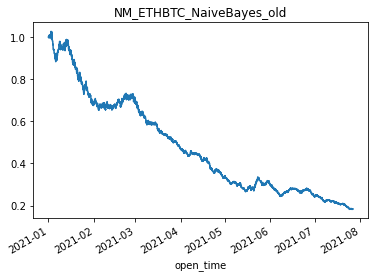

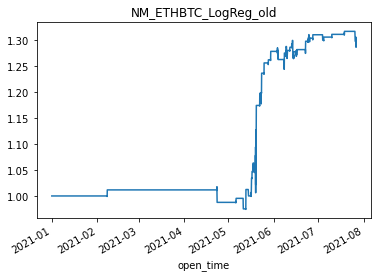

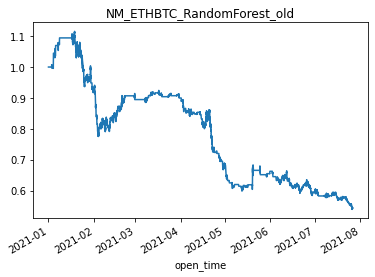

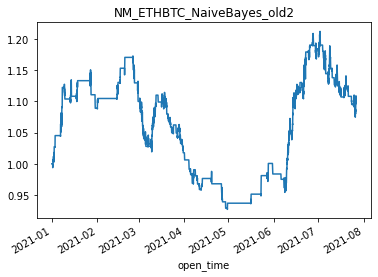

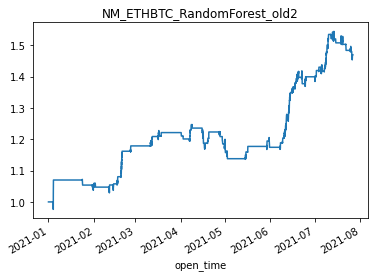

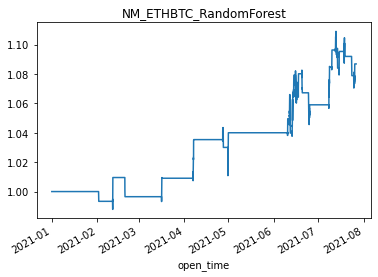

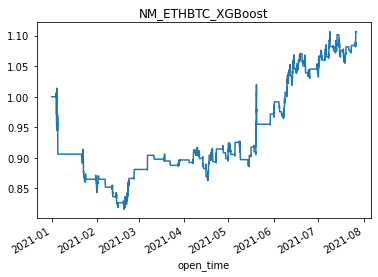

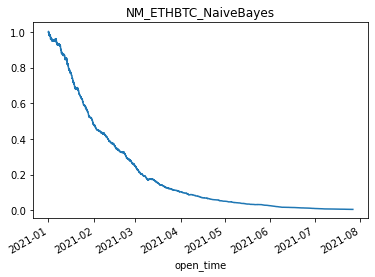

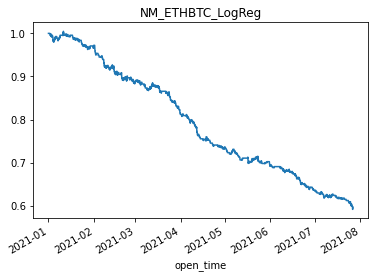

In [10]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    v[v['actual_action']!='none'].to_csv(f'./results/{k}.csv')
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')
    ax.set_title(k)
    v.total_value.plot(figure=fig)

# Further Analysis

In [11]:
model_to_analyze = 'NM_ETHBTC_NaiveBayes'

df = simulation_results[model_to_analyze][['open','high','low','close','execute_price','actual_action','total_value']].copy()
df = df[df.actual_action!= 'none']
df['profit'] = df.total_value.diff()
df['price_diff'] = df.execute_price.diff()
df['target_sale'] = (df.actual_action=='sell') & (df.price_diff<0)
df['stoploss_sale'] = (df.actual_action=='sell') & (df.price_diff>0)
df['target_loss'] = (df['target_sale']==True) & (df['profit'] < 0)
df


,open,high,low,close,execute_price,actual_action,total_value,profit,price_diff,target_sale,stoploss_sale,target_loss
open_time,,,,,,,,,,,,
2021-01-01 00:00:00,0.025464,0.025479,0.025383,0.025426,0.025426,buy,0.999000,NaN,NaN,False,False,False
2021-01-01 01:00:00,0.025317,0.025345,0.025230,0.025300,0.025299,sell,1.003016,0.004016,-0.000127,True,False,False
2021-01-01 01:15:00,0.025300,0.025334,0.025244,0.025256,0.025256,buy,1.002013,-0.001003,-0.000043,False,False,False
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,0.025319,sell,0.998515,-0.003498,0.000063,False,True,False
2021-01-01 02:30:00,0.025423,0.025547,0.025402,0.025434,0.025434,buy,0.997516,-0.000999,0.000115,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26 20:45:00,0.059841,0.060095,0.059650,0.060022,0.060022,buy,0.005792,-0.000006,0.000369,False,False,False
2021-07-26 21:15:00,0.060036,0.060198,0.059700,0.059845,0.059722,sell,0.005815,0.000023,-0.000300,True,False,False
2021-07-26 21:45:00,0.060052,0.060218,0.059925,0.060194,0.060194,buy,0.005809,-0.000006,0.000472,False,False,False


In [12]:
a = len(df[df.actual_action== 'sell'])
p = (df[df.actual_action=='sell']['profit']>0).sum()
l = (df[df.actual_action=='sell']['profit']<0).sum()
t = df[df.actual_action=='sell'].target_loss.sum()
print('Percent of profitable transactions:', p/a)
print('Percent of loss transactions:', l/a)
print('Percent of losses when selling on target:', t/a)

Percent of profitable transactions: 0.3594405594405594
Percent of loss transactions: 0.6405594405594406
Percent of losses when selling on target: 0.0


In [32]:
df[df['target_sale']==True]

,open,high,low,close,execute_price,actual_action,total_value,profit,price_diff,target_sale,stoploss_sale,target_loss
open_time,,,,,,,,,,,,
2021-01-01 01:00:00,0.025317,0.025345,0.025230,0.025300,0.025299,sell,1.003016,0.004016,-0.000127,True,False,False
2021-01-01 06:30:00,0.025349,0.025349,0.025305,0.025333,0.025307,sell,0.998450,0.003998,-0.000127,True,False,False
2021-01-01 08:00:00,0.025344,0.025356,0.025244,0.025282,0.025264,sell,1.001462,0.004010,-0.000127,True,False,False
2021-01-01 17:30:00,0.025059,0.025079,0.024996,0.025034,0.025023,sell,1.004482,0.004022,-0.000126,True,False,False
2021-01-01 18:45:00,0.024956,0.025022,0.024890,0.024932,0.024917,sell,1.007512,0.004034,-0.000125,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26 10:45:00,0.061246,0.061283,0.060964,0.061042,0.061006,sell,0.039171,0.000157,-0.000307,True,False,False
2021-07-26 12:30:00,0.060727,0.060743,0.060603,0.060649,0.060640,sell,0.039289,0.000157,-0.000305,True,False,False
2021-07-26 16:15:00,0.060658,0.060769,0.060424,0.060610,0.060443,sell,0.039407,0.000158,-0.000304,True,False,False


In [28]:
df.loc['2021-01-01']

,open,high,low,close,trade_model_decision,execute_price,actual_action,fund1,fund2,total_value
open_time,,,,,,,,,,
2021-01-01 00:00:00,0.025464,0.025479,0.025383,0.025426,1,0.025426,buy,0.000000,0.025401,0.999000
2021-01-01 00:15:00,0.025430,0.025433,0.025325,0.025368,0,0.000000,none,0.000000,0.025401,1.001284
2021-01-01 00:30:00,0.025373,0.025385,0.025324,0.025356,0,0.000000,none,0.000000,0.025401,1.001758
2021-01-01 00:45:00,0.025355,0.025388,0.025307,0.025318,0,0.000000,none,0.000000,0.025401,1.003261
2021-01-01 01:00:00,0.025317,0.025345,0.025230,0.025300,-1,0.025299,sell,1.003016,0.000000,1.003016
...,...,...,...,...,...,...,...,...,...,...
2021-01-01 22:45:00,0.024870,0.024929,0.024864,0.024911,0,0.000000,none,0.000000,0.025029,1.004727
2021-01-01 23:00:00,0.024911,0.024929,0.024888,0.024920,0,0.000000,none,0.000000,0.025029,1.004364
2021-01-01 23:15:00,0.024925,0.024932,0.024875,0.024891,0,0.000000,none,0.000000,0.025029,1.005534


## Plotting

(<Figure size 800x575 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x21b4ac62490>])

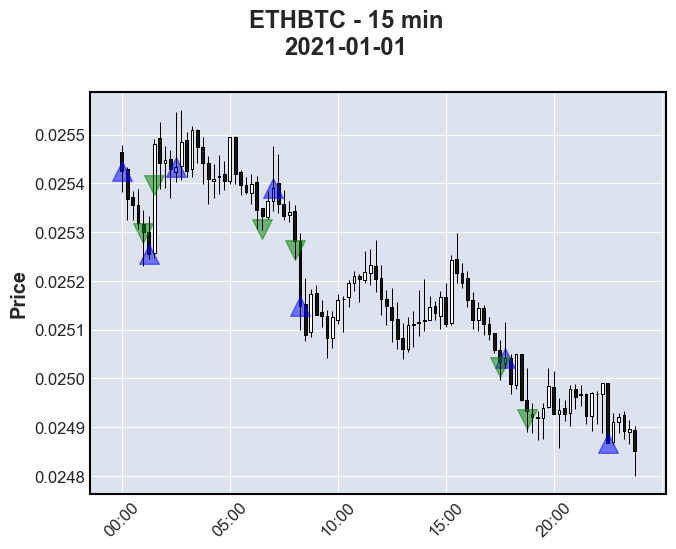

In [26]:
import mplfinance as mpf
import matplotlib.pyplot as plt

def plot_buy_sells(df):
    
    def build_subplot(df, idxs=[]):
        signals = pd.Series(np.NaN, index=df.index)
        prices = df.loc[idxs]['execute_price'].values
        for i,p in zip(idxs,prices):
            signals.at[i]=p
        return signals
    
    decisions = df.trade_model_decision
    
    date = datetime.strftime(df.index[0],'%Y-%m-%d')
    
    buy_signal = build_subplot(df, decisions[decisions==1].index)
    sell_signal = build_subplot(df, decisions[decisions==-1].index)
    
    
    apds=[mpf.make_addplot(buy_signal, type='scatter', markersize=200, marker='^',color='b', alpha=0.5),
          mpf.make_addplot(sell_signal, type='scatter', markersize=200, marker='v',color='g', alpha=0.5),
         ]

    fig, ax = mpf.plot(df,
                       type='candlestick',
                       title=f"ETHBTC - 15 min\n{date}",
                       returnfig=True,
                       addplot=apds,
                      )
    
    return fig,ax

df = simulation_results[model_to_analyze].copy()
plot_buy_sells(df.loc['2021-01-01':'2021-01-01'])

In [16]:
all_ports = {p['portfolio_name']: p for p in portfolios}
portfolio = all_ports[model_to_analyze]

portfolio_name = portfolio['portfolio_name']
trade_model = portfolio['trade_model']
starting_coin = portfolio['starting_coin']
pair_coin = portfolio['pair_coin']
max_batch_size = portfolio['max_batch_size']
extra_rows = portfolio['extra_rows']
starting_funds = portfolio['starting_funds']
fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
trading_fees_buy = portfolio['trading_fees_buy']
trading_fees_sell = portfolio['trading_fees_sell']

model = trade_models.__dict__[trade_model]
columns = model.columns()
info_dict = {'portfolio':portfolio}

current_time = '2021-01-01'
end_time = '2021-06-29'

batch_data, ref_data, extra_data, batch_close_time = get_batch_data(starting_coin, pair_coin, current_time, end_time, columns, max_batch_size, extra_rows, True)
batch_model_decision, batch_execute_price = model.make_decision(batch_data[columns], extra_data, info_dict)
batch_data['trade_model_decision'] = batch_model_decision.values
batch_data['execute_price'] = batch_execute_price.values

Using cache file: ./cache_data/695517af1a1bd8d3e60bd119d30475ce.pkl


In [17]:
batch_data[batch_data.trade_model_decision != 0]

,open,high,low,close,dow,tod,number_of_trades,volume,quote_asset_volume,taker_buy_base_asset_volume,...,cs_ss,cs_ssr,cs_hm,cs_hmr,cs_brh,cs_buh,cs_ebu,cs_ebr,trade_model_decision,execute_price
candle_open_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.025464,0.025479,0.025383,0.025426,5,0.000000,1935,3166.232,80.524236,1365.120,...,False,False,False,False,False,False,False,False,1,0.025426
2021-01-01 01:00:00,0.025317,0.025345,0.025230,0.025300,5,0.041667,3633,6797.630,172.137236,4802.724,...,False,False,False,False,False,False,False,False,-1,0.025299
2021-01-01 01:15:00,0.025300,0.025334,0.025244,0.025256,5,0.052083,2317,3953.972,99.953123,2078.360,...,False,False,False,False,False,False,False,False,1,0.025256
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,5,0.062500,2312,3055.958,77.529331,1597.593,...,False,False,False,False,False,False,False,False,-1,0.025397
2021-01-01 02:30:00,0.025423,0.025547,0.025402,0.025434,5,0.104167,2447,4453.311,113.378433,2536.264,...,True,False,False,False,False,False,False,False,1,0.025434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15 01:00:00,0.038531,0.038612,0.038335,0.038433,4,0.041667,5199,3717.958,143.055181,1655.711,...,False,False,False,False,False,False,False,False,-1,0.038455
2021-04-15 02:00:00,0.038597,0.038731,0.038583,0.038613,4,0.083333,3283,1819.647,70.338953,863.257,...,True,False,False,False,False,False,False,False,1,0.038613
2021-04-15 03:15:00,0.038629,0.038874,0.038620,0.038874,4,0.135417,3721,2486.757,96.350244,1288.468,...,False,False,False,False,False,False,False,False,-1,0.038828


In [33]:
date = '2021-01-01 01:15:00'
use_atr=False
ratio=(0.005, 0.0025)
reverse=True

targets, stop_losses = model.get_target_stoploss(batch_data, use_atr=use_atr, atr_ratio=ratio, threshold_ratio=ratio, reverse=reverse)
print('Close:',batch_data.loc[date,'close'])
print('High:',batch_data.loc[date,'high'])
print('Low:',batch_data.loc[date,'low'])
print('ATR:',batch_data.loc[date,'atr'])
print('ATR14:',batch_data.loc[date,'atr_ma14'])
print('Target:',targets[date])
print('Stoploss:',stop_losses[date])

Close: 0.025256
High: 0.025334
Low: 0.025244
ATR: 8.935714285714285e-05
ATR14: 8.682142857142858e-05
Target: 0.02512972
Stoploss: 0.02539714


In [19]:
df = batch_data.loc[date]
df.high+(df.atr*1)
df.close-(df.atr*2)

0.03453671428571429

In [20]:
batch_data['tr'] = batch_data.high - batch_data.low
batch_data[['high','low','close','atr','tr']]

,high,low,close,atr,tr
candle_open_time,,,,,
2021-01-01 00:00:00,0.025479,0.025383,0.025426,0.000089,0.000096
2021-01-01 00:15:00,0.025433,0.025325,0.025368,0.000092,0.000108
2021-01-01 00:30:00,0.025385,0.025324,0.025356,0.000090,0.000061
2021-01-01 00:45:00,0.025388,0.025307,0.025318,0.000086,0.000081
2021-01-01 01:00:00,0.025345,0.025230,0.025300,0.000089,0.000115
...,...,...,...,...,...
2021-04-15 05:30:00,0.039155,0.039010,0.039074,0.000162,0.000145
2021-04-15 05:45:00,0.039136,0.039053,0.039134,0.000161,0.000083
2021-04-15 06:00:00,0.039283,0.039035,0.039145,0.000165,0.000248


In [21]:
#df.groupby(pd.Grouper(freq='1h')).mean()
#df.groupby(df.open_time.hour).mean()
#df.reset_index().groupby(df.reset_index()['open_time'].dt.hour).mean()
df = batch_data.reset_index()
df.groupby(df['candle_open_time'].dt.hour).agg(['mean','std']).atr

,mean,std
candle_open_time,,
0,0.000203,0.000098
1,0.000205,0.000105
2,0.000206,0.000106
3,0.000196,0.000105
4,0.000188,0.000102
5,0.000176,0.000094
6,0.000172,0.000097
7,0.000170,0.000103
8,0.000176,0.000115
